In [87]:
from IPython.core.display import HTML, display
from collections import namedtuple as NT

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, LeaveOneOut
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as pl
from matplotlib import rcParams

from keras import models
from keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Flatten
from keras import regularizers
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasRegressor
from keras.utils import plot_model
from keras import backend as K
K.set_image_dim_ordering('tf')

In [2]:
display(HTML("<style>.container {width:90% !important}</style>"))

In [3]:
% matplotlib inline
rcParams['axes.labelsize'] = 16
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['font.size'] = 16
rcParams['axes.titlesize'] = 18
rcParams['figure.titlesize'] = 20

In [4]:
band = 411
d_ = pd.read_pickle('./pickleJar/OperationalDataSets/df_6_APHY_Standardized_SWF_SAT.pkl')

In [95]:
def build_cnn_model():
    l1_decay = 0.00001
    model = models.Sequential()
    model.add(Conv1D(128, kernel_size=(5,), strides=4, activation='relu', padding='same', input_shape=((6,1)),
                    kernel_regularizer=regularizers.l1(l1_decay)))
    model.add(Dropout(0.5))
    model.add(Conv1D(64, kernel_size=5, strides=4, activation='relu', padding='same'))
    model.add(Dropout(0.5))
    model.add(Conv1D(32, kernel_size=5, strides=4, activation='relu', padding='same'))
    model.add(Dropout(0.5))
    model.add(Dense(163, activation='relu', kernel_regularizer=regularizers.l1(l1_decay)))
    model.add(Dense(163, activation='relu', kernel_regularizer=regularizers.l1(l1_decay)))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [113]:
def Cross_Fold_Validation(X_, y_, model_, k=4, num_epochs=100, verbose=0):
    results = dict(fold_val_mae=[], fold_val_mse=[],
                   val_mae_histories=[], train_mae_histories=[])
    kfold = KFold(n_splits=k, )
    for train_idx, val_idx in kfold.split(X_):
        history = model_.fit(X_[train_idx], y_[train_idx], epochs=num_epochs,
                            validation_data=(X_[val_idx], y_[val_idx]),
                            batch_size=1,  verbose=verbose)
        val_mse, val_mae = model_.evaluate(X_[val_idx], y_[val_idx], verbose=0)
        results['fold_val_mae'].append(val_mae)
        results['fold_val_mse'].append(val_mse)
        results['val_mae_histories'].append(history.history['val_mean_absolute_error'])
        results['train_mae_histories'].append(history.history['mean_absolute_error'])
    return results


def plot_mae_history(train_mae_histories, val_mae_histories):
    avg_val_mae_history = [np.mean([x[i] for x in val_mae_histories])
                           for i in range(num_epochs)]
    avg_train_mae_history = [np.mean([x[i] for x in train_mae_histories])
                           for i in range(num_epochs)]
    pl.plot(range(1, len(avg_val_mae_history) + 1), avg_val_mae_history, label='val')
    pl.plot(range(1, len(avg_train_mae_history) + 1), avg_train_mae_history, label='train',
           color='r')
    pl.xlabel('Epochs')
    pl.ylabel('MAE');

    
def plot_fits(model_, x_test_, y_test_):
    y_pred = model_.predict(x_test_)
    _, ax = pl.subplots(figsize=(10, 10))
    r2_  = r2_score(y_test_, y_pred)
    mae = mean_absolute_error(y_test_, y_pred, )
    min_ = min(y_pred.min(), y_test_.min())
    max_ = max(y_pred.max(), y_test_.max())
    ax.plot([min_, max_],[min_, max_], ls='--', color='k', label='1:1')
    ax.scatter(y_pred, y_test_, label='$r^2$ = %.2f, mae = %.2f' %(r2_, mae))
    ax.set_xlabel('predicted')
    ax.set_ylabel=('observed')
    ax.legend()
    ax.set_title('MLP - Test Data')

    
def plot_fits_2(model_, x_test_, y_test_):
    y_pred = model_.predict(x_test_)
    ix = np.argsort(y_test_)
    xi = np.arange(ix.size)
    _, ax = pl.subplots(figsize=(12, 8))
    ax.scatter(xi, y_test_[ix], color='steelblue', edgecolor='k', s=50, label='observed')
    ax.scatter(xi, y_pred[ix], color='m', edgecolor='k', s=50, label='predicted')
    ax.legend();

In [7]:
X_sat = d_.dropna().filter(regex='sat')
y = d_.dropna().loc[:, 'log10_aphy%d' % band]

In [8]:
assert X_sat.shape[0] == y.size

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_sat, y, test_size=0.1, random_state=42)

In [84]:
y_train_ = y_train.values.reshape((-1,1))

In [115]:
y_test_ = y_test.values

In [29]:
X_train_ = np.expand_dims(X_train.values, 2)
X_test_ = np.expand_dims(X_test.values, 2)

In [31]:
X_train_.shape, X_test_.shape

((145, 6, 1), (17, 6, 1))

In [101]:
model_cnn = build_cnn_model()

In [117]:
model_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_44 (Conv1D)           (None, 2, 128)            768       
_________________________________________________________________
dropout_22 (Dropout)         (None, 2, 128)            0         
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 1, 64)             41024     
_________________________________________________________________
dropout_23 (Dropout)         (None, 1, 64)             0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 1, 32)             10272     
_________________________________________________________________
dropout_24 (Dropout)         (None, 1, 32)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 1, 163)            5379      
__________

In [102]:
num_epochs=1000
results_model_cnn = Cross_Fold_Validation(X_train_, y_train_, model_=model_cnn, num_epochs=num_epochs)

In [103]:
results_model_cnn['fold_val_mae']

[0.12605918380054268,
 0.1731115910742018,
 0.14261228839556375,
 0.12282125817404853]

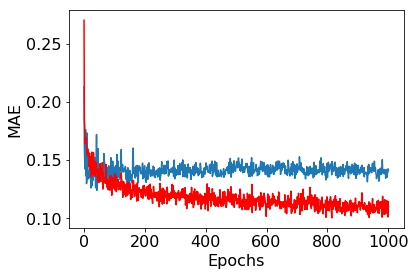

In [104]:
plot_mae_history(results_model_cnn['train_mae_histories'], results_model_cnn['val_mae_histories'])

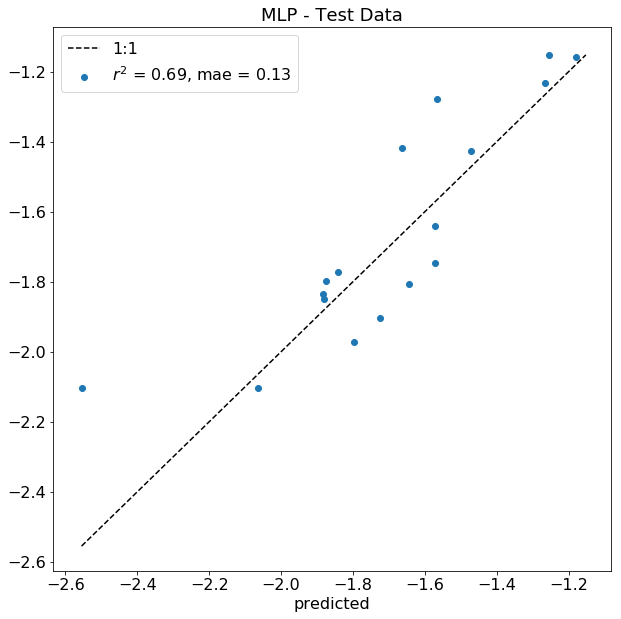

In [110]:
plot_fits(model_cnn, X_test_, y_test_)

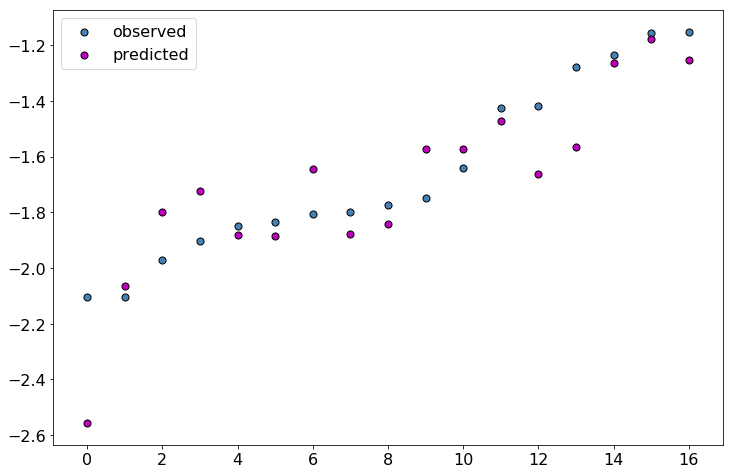

In [116]:
plot_fits_2(model_cnn, X_test_, y_test_)